# Arima

## Preprocessing

In [1]:
import pandas as pd
import tensorflow as tf

In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = "/content/drive/MyDrive/Colab Notebooks/AAI-530/Final Project/aai-530-iot-smart-house/Data/Final_Combined_Data.csv"

df = pd.read_csv(file_path)

df.head()

,DateTime,RH (%),eCO₂ (ppm),Inside Dew Point - °C,Inside Heat Index - °C,Barometer - mb,Inside Temp - °C,Sensor
0,2022-12-31 23:53:24,73.0,518.0,6.9,12.3,1002.6,12.3,EcoLab Ground
1,2023-01-01 00:00:00,68.0,518.0,8.0,13.0,1002.6,13.0,WeatherLink
2,2023-01-01 00:00:55,73.0,520.0,7.0,12.4,1002.6,12.4,EcoLab Ground
3,2023-01-01 00:08:23,73.0,505.0,7.0,12.4,1002.6,12.4,EcoLab Ground
4,2023-01-01 00:15:00,68.0,505.0,8.0,13.0,1002.7,13.0,WeatherLink


In [4]:
# Convert 'DateTime' column to datetime format
df["DateTime"] = pd.to_datetime(df["DateTime"], errors="coerce")

# Verify conversion
df.info()  # Check if 'DateTime' is now datetime64[ns]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112622 entries, 0 to 112621
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   DateTime                112622 non-null  datetime64[ns]
 1   RH (%)                  112622 non-null  float64       
 2   eCO₂ (ppm)              112622 non-null  float64       
 3   Inside Dew Point - °C   112622 non-null  float64       
 4   Inside Heat Index - °C  112622 non-null  float64       
 5   Barometer - mb          112622 non-null  float64       
 6   Inside Temp - °C        112622 non-null  float64       
 7   Sensor                  112622 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 6.9+ MB


In [5]:
# Define the range
start_date = "2023-06-01"
end_date = "2023-11-30"

# Filter the DataFrame
df_filtered = df[(df["DateTime"] >= start_date) & (df["DateTime"] <= end_date)].copy()

# Verify the filtering
print(df_filtered["DateTime"].min(), "to", df_filtered["DateTime"].max())  # Confirm date range
print(df_filtered.shape)  # Check new dimensions

2023-06-01 00:00:00 to 2023-11-30 00:00:00
(65706, 8)


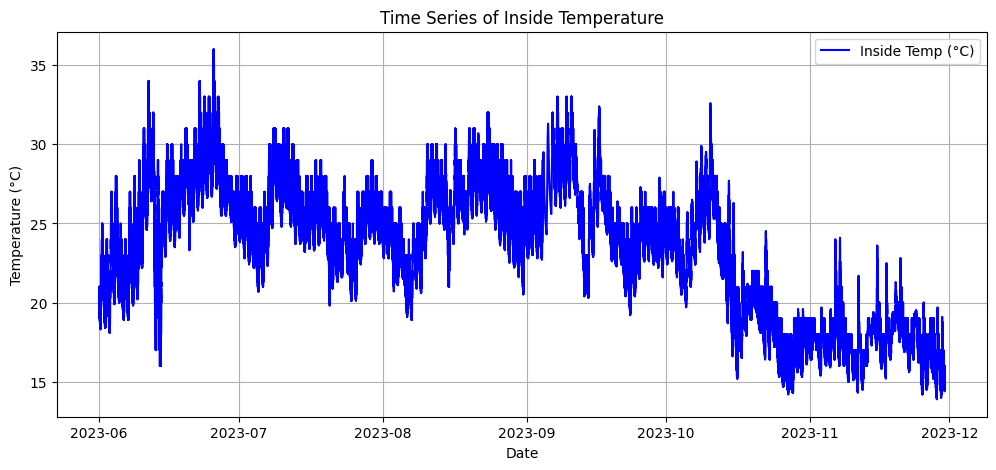

ADF Test Statistic: -6.16550687116599
p-value: 7.006003224318241e-08
Critical Values:
1%: -3.4304496184950075
5%: -2.8615840295601678
10%: -2.566793435438414
The data is stationary. No differencing needed.


In [6]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Plot the time series
plt.figure(figsize=(12, 5))
plt.plot(df_filtered["DateTime"], df_filtered["Inside Temp - °C"], label="Inside Temp (°C)", color="blue")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Time Series of Inside Temperature")
plt.legend()
plt.grid()
plt.show()

# Perform the Augmented Dickey-Fuller test
adf_test = adfuller(df_filtered["Inside Temp - °C"].dropna())

# Print test results
print(f"ADF Test Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
print("Critical Values:")
for key, value in adf_test[4].items():
    print(f"{key}: {value}")

# Interpretation
if adf_test[1] < 0.05:
    print("The data is stationary. No differencing needed.")
else:
    print("The data is non-stationary. Differencing is required.")

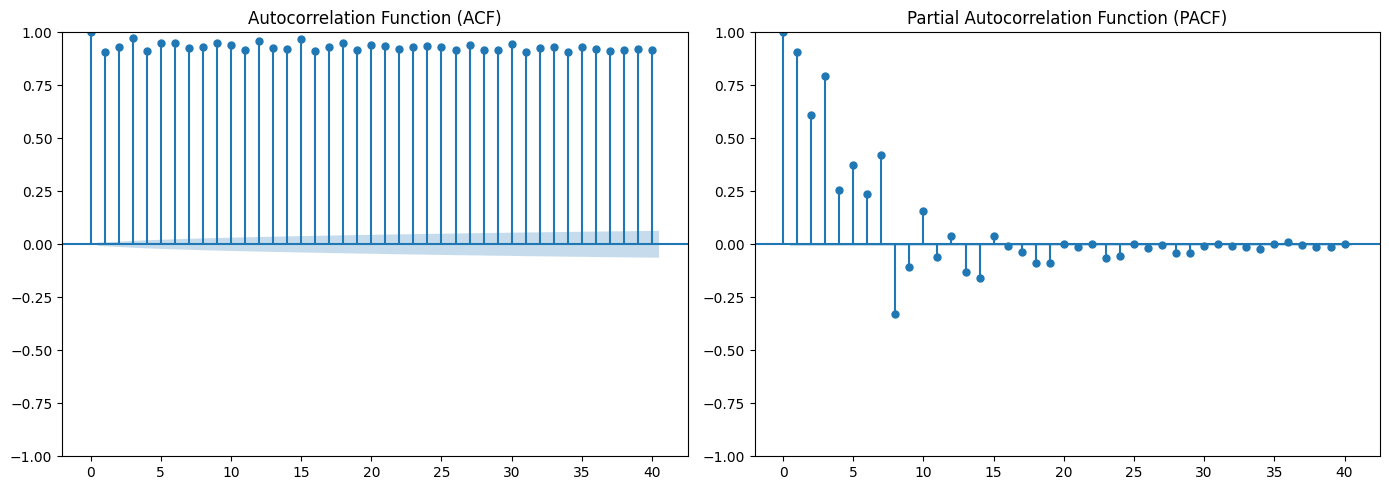

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF plot (for determining q)
plot_acf(df_filtered["Inside Temp - °C"], lags=40, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

# PACF plot (for determining p)
plot_pacf(df_filtered["Inside Temp - °C"], lags=40, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

In [8]:
# Define the split point (e.g., 80% training, 20% testing)
split_ratio = 0.8
split_index = int(len(df_filtered) * split_ratio)

# Split the dataset
train_df = df_filtered.iloc[:split_index]
test_df = df_filtered.iloc[split_index:]

# Display the shapes of the splits
print(f"Training set size: {train_df.shape}")
print(f"Testing set size: {test_df.shape}")

Training set size: (52564, 8)
Testing set size: (13142, 8)


## Model Selection

In [9]:
from statsmodels.tsa.arima.model import ARIMA

# Define and fit the ARIMA model on the training set
baseline_arima = ARIMA(train_df["Inside Temp - °C"], order=(3, 0, 2))
baseline_model_fit = baseline_arima.fit()

# Print the model summary
print(baseline_model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

                               SARIMAX Results                                
Dep. Variable:       Inside Temp - °C   No. Observations:                52564
Model:                 ARIMA(3, 0, 2)   Log Likelihood              -59518.065
Date:                Fri, 07 Feb 2025   AIC                         119050.131
Time:                        14:25:57   BIC                         119112.219
Sample:                             0   HQIC                        119069.535
                              - 52564                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.4490      1.151     21.233      0.000      22.192      26.706
ar.L1         -0.0316      0.005     -5.859      0.000      -0.042      -0.021
ar.L2          0.2891      0.003     89.100      0.0

In [ ]:
import itertools
import warnings
from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")  # Ignore warnings

# Define expanded range for p, d, q
p = range(0, 9)  # Testing up to 8 based on PACF
d = range(0, 2)  # d = 0 or 1 based on ADF test
q = range(0, 5)  # Testing up to 4 for MA terms

# Generate all possible (p, d, q) combinations
pdq_combinations = list(itertools.product(p, d, q))

best_aic = float("inf")
best_order = None
best_model = None

# Perform Grid Search with Progress Bar
for order in tqdm(pdq_combinations, desc="Evaluating ARIMA Models", unit="model"):
    try:
        model = ARIMA(train_df["Inside Temp - °C"], order=order)
        model_fit = model.fit()
        aic = model_fit.aic  # Get AIC value

        if aic < best_aic:
            best_aic = aic
            best_order = order
            best_model = model_fit

    except:
        continue  # Skip models that fail to converge

# Print best model parameters and AIC
print(f"\nBest ARIMA Order: {best_order}")
print(f"Best AIC: {best_aic}")
print(best_model.summary())

Evaluating ARIMA Models: 100%|██████████| 90/90 [56:22<00:00, 37.58s/model]



Best ARIMA Order: (7, 1, 4)
Best AIC: 98894.00687420722
                               SARIMAX Results                                
Dep. Variable:       Inside Temp - °C   No. Observations:                52564
Model:                 ARIMA(7, 1, 4)   Log Likelihood              -49435.003
Date:                Thu, 06 Feb 2025   AIC                          98894.007
Time:                        03:09:02   BIC                          99000.444
Sample:                             0   HQIC                         98927.271
                              - 52564                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.3515      0.010   -228.187      0.000      -2.372      -2.331
ar.L2         -3.5948      0.021   -169.866      0.000      -3.636      -3

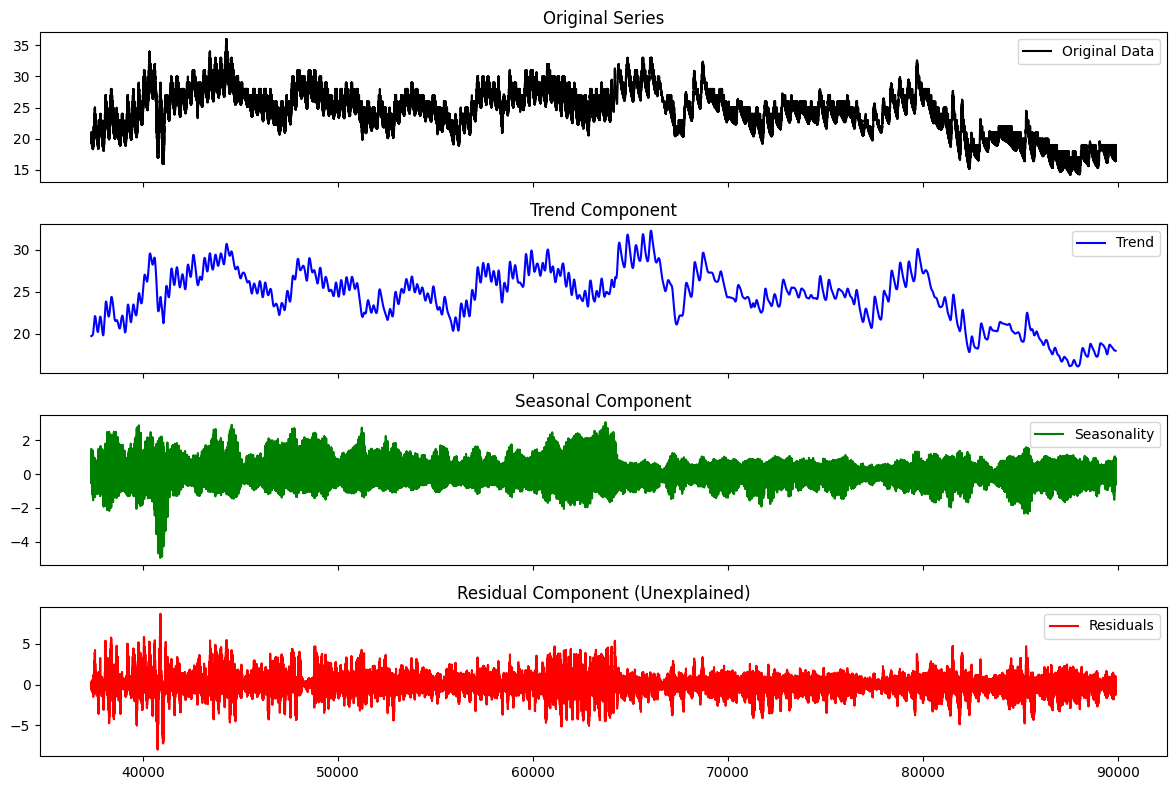

In [ ]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

# Perform STL decomposition on the training data
stl = STL(train_df["Inside Temp - °C"], period=96, robust=True)  # 96 = daily cycle (15-min intervals)
result = stl.fit()

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

# Original Series
axes[0].plot(train_df["Inside Temp - °C"], label="Original Data", color="black")
axes[0].set_title("Original Series")
axes[0].legend()

# Trend Component
axes[1].plot(result.trend, label="Trend", color="blue")
axes[1].set_title("Trend Component")
axes[1].legend()

# Seasonal Component
axes[2].plot(result.seasonal, label="Seasonality", color="green")
axes[2].set_title("Seasonal Component")
axes[2].legend()

# Residuals
axes[3].plot(result.resid, label="Residuals", color="red")
axes[3].set_title("Residual Component (Unexplained)")
axes[3].legend()

plt.tight_layout()
plt.show()

This shows seasonal data is weak and not required. will explain more later

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define exogenous variables (X) - dropping any missing values
exog_features = ["RH (%)", "Barometer - mb", "Inside Dew Point - °C", "Inside Heat Index - °C"]
train_X = train_df[exog_features].dropna()
test_X = test_df[exog_features].dropna()

# Align target variable with exogenous data
train_y = train_df.loc[train_X.index, "Inside Temp - °C"]
test_y = test_df.loc[test_X.index, "Inside Temp - °C"]

# Use the best (p, d, q) from previous Grid Search
best_p, best_d, best_q = best_order  # 7, 1, 4 (if want to skip the grid search)

# Fit SARIMAX Model
sarimax_model = SARIMAX(
    train_y, exog=train_X, order=(best_p, best_d, best_q),
    enforce_stationarity=False, enforce_invertibility=False
)
sarimax_results = sarimax_model.fit()

# Print Model Summary
print(sarimax_results.summary())

                               SARIMAX Results                                
Dep. Variable:       Inside Temp - °C   No. Observations:                52564
Model:               SARIMAX(7, 1, 4)   Log Likelihood                1280.698
Date:                Thu, 06 Feb 2025   AIC                          -2529.396
Time:                        03:28:00   BIC                          -2387.482
Sample:                             0   HQIC                         -2485.045
                              - 52564                                         
Covariance Type:                  opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
RH (%)                    -0.1664      0.001   -249.365      0.000      -0.168      -0.165
Barometer - mb            -0.0310      0.005     -5.764      0.000      -0.042      -0.020
Insi

# Sarimax final model and evaluation

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define exogenous variables (X) - dropping any missing values
exog_features = ["RH (%)", "Barometer - mb", "Inside Dew Point - °C", "Inside Heat Index - °C"]
train_X = train_df[exog_features].dropna()
test_X = test_df[exog_features].dropna()

# Align target variable with exogenous data
train_y = train_df.loc[train_X.index, "Inside Temp - °C"]
test_y = test_df.loc[test_X.index, "Inside Temp - °C"]

# Fit Final SARIMAX Model
final_sarimax_model = SARIMAX(
    train_y,
    exog=train_X,
    order=(7, 1, 4),  # Best (p, d, q) from Grid Search
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Train the model
final_sarimax_results = final_sarimax_model.fit()

# Print Model Summary
print(final_sarimax_results.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:       Inside Temp - °C   No. Observations:                52564
Model:               SARIMAX(7, 1, 4)   Log Likelihood                1280.698
Date:                Fri, 07 Feb 2025   AIC                          -2529.396
Time:                        14:56:46   BIC                          -2387.482
Sample:                             0   HQIC                         -2485.045
                              - 52564                                         
Covariance Type:                  opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
RH (%)                    -0.1664      0.001   -249.365      0.000      -0.168      -0.165
Barometer - mb            -0.0310      0.005     -5.764      0.000      -0.042      -0.020
Insi

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Generate predictions on the test set
test_predictions = final_sarimax_results.predict(start=len(train_y), end=len(train_y) + len(test_y) - 1, exog=test_X)

# Compute Evaluation Metrics
rmse = np.sqrt(mean_squared_error(test_y, test_predictions))
mae = mean_absolute_error(test_y, test_predictions)
r2 = r2_score(test_y, test_predictions)

# Print Results
print(f"Model Evaluation Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"AIC: {final_sarimax_results.aic:.2f}")
print(f"BIC: {final_sarimax_results.bic:.2f}")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Model Evaluation Metrics:
RMSE: 1.0248
MAE: 0.8073
R² Score: 0.4901
AIC: -2529.40
BIC: -2387.48


In [12]:
# Define forecast horizon
forecast_steps = [25, 150, 600]  # 1-hour, 6-hour, 24-hour forecasts

# Store predictions
forecast_results = {}

# Generate forecasts for different horizons
for steps in forecast_steps:
    forecast = final_sarimax_results.forecast(steps=steps, exog=test_X.iloc[:steps])
    forecast_results[f"{steps}_steps"] = forecast

# Display forecasts
for key, value in forecast_results.items():
    print(f"\nForecast for {key.replace('_steps', '')} future time steps:\n", value)


Forecast for 25 future time steps:
 52564    18.309739
52565    16.435149
52566    18.879282
52567    16.239431
52568    18.779723
52569    18.808530
52570    16.309229
52571    18.753237
52572    16.493921
52573    18.462497
52574    18.589650
52575    16.418488
52576    18.464727
52577    16.412780
52578    18.591856
52579    18.481250
52580    16.426906
52581    18.553748
52582    16.314236
52583    18.453916
52584    18.378317
52585    16.349982
52586    18.432861
52587    16.347897
52588    18.398641
Name: predicted_mean, dtype: float64

Forecast for 150 future time steps:
 52564    18.309739
52565    16.435149
52566    18.879282
52567    16.239431
52568    18.779723
           ...    
52709    18.638396
52710    16.859946
52711    18.641499
52712    18.644598
52713    16.930206
Name: predicted_mean, Length: 150, dtype: float64

Forecast for 600 future time steps:
 52564    18.309739
52565    16.435149
52566    18.879282
52567    16.239431
52568    18.779723
           ...    
53

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


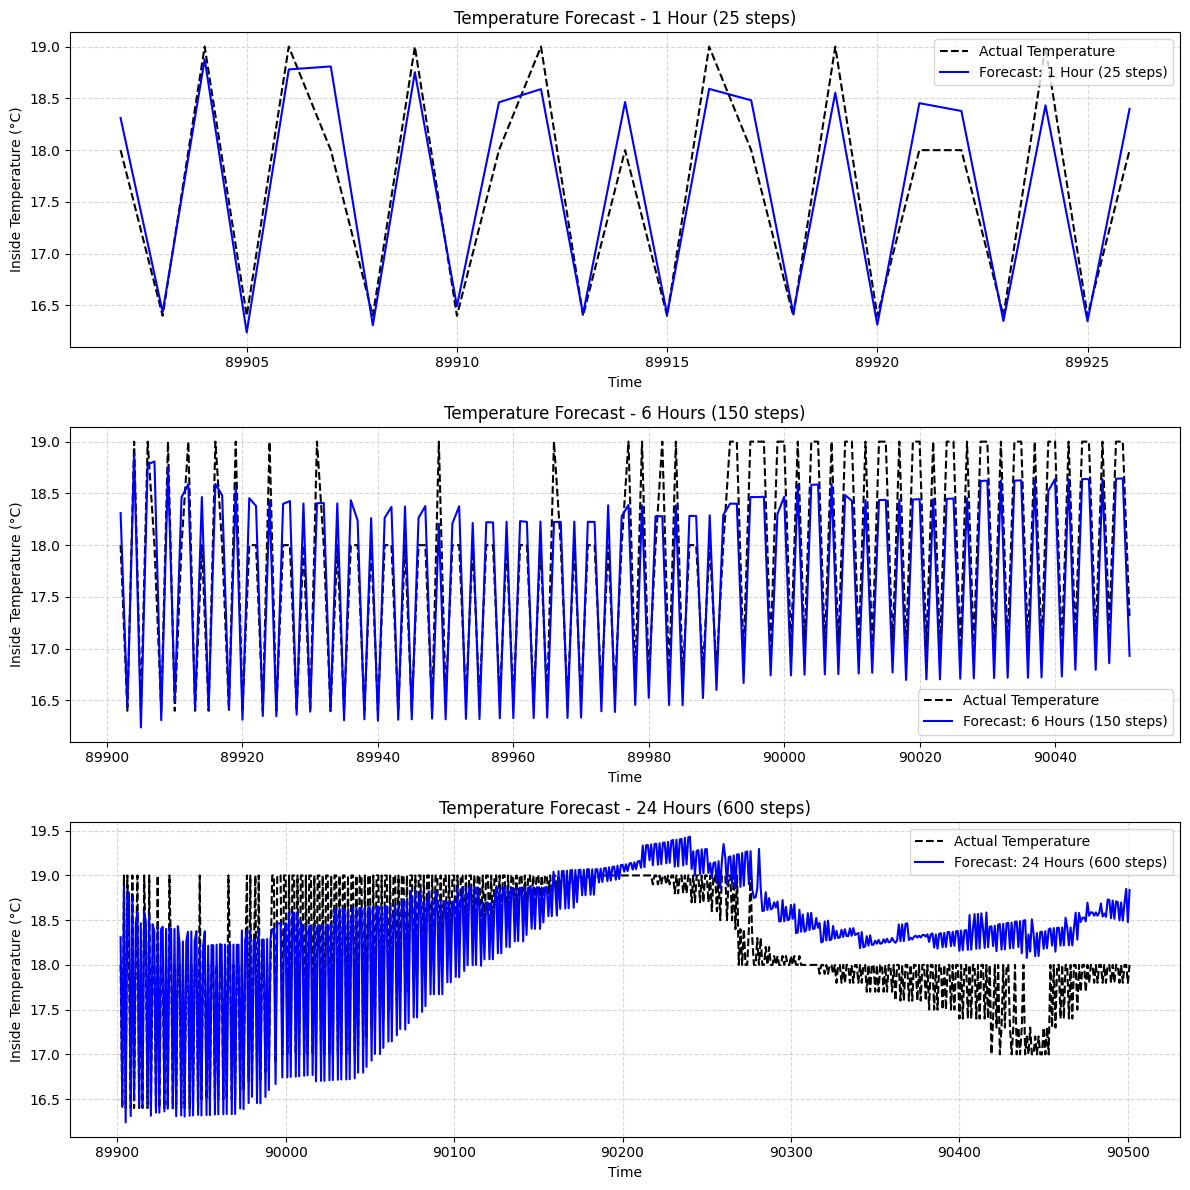

In [14]:
import matplotlib.pyplot as plt

# This is from one time point. it is only precition for about 25 steps then 150 steps then 600 steps

# Define forecast horizons
forecast_horizons = {
    "1 Hour (25 steps)": forecast_results["25_steps"],
    "6 Hours (150 steps)": forecast_results["150_steps"],
    "24 Hours (600 steps)": forecast_results["600_steps"]
}

# Create separate plots for each forecast horizon
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))

for ax, (label, forecast) in zip(axes, forecast_horizons.items()):
    ax.plot(test_y.index[:len(forecast)], test_y[:len(forecast)], label="Actual Temperature", color="black", linestyle="dashed")
    ax.plot(test_y.index[:len(forecast)], forecast, label=f"Forecast: {label}", color="blue")

    ax.set_xlabel("Time")
    ax.set_ylabel("Inside Temperature (°C)")
    ax.set_title(f"Temperature Forecast - {label}")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.5)

# Adjust layout for clarity
plt.tight_layout()
plt.show()

Rolling Forecasting: 100%|██████████| 13142/13142 [07:48<00:00, 28.06step/s] 


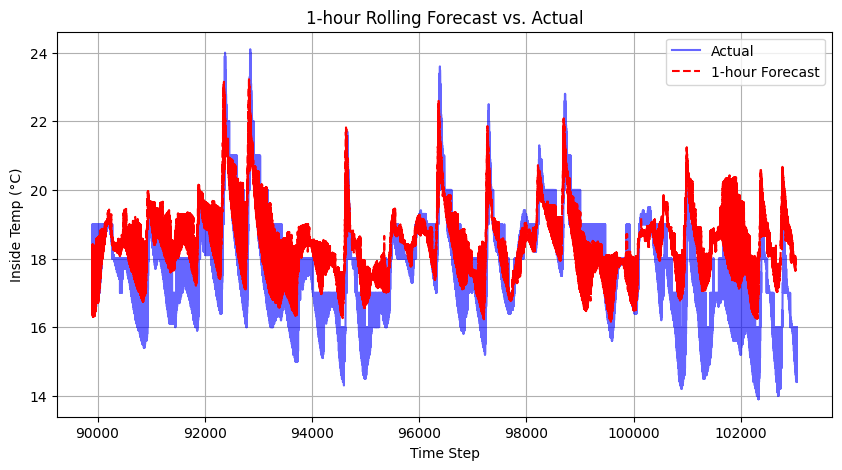

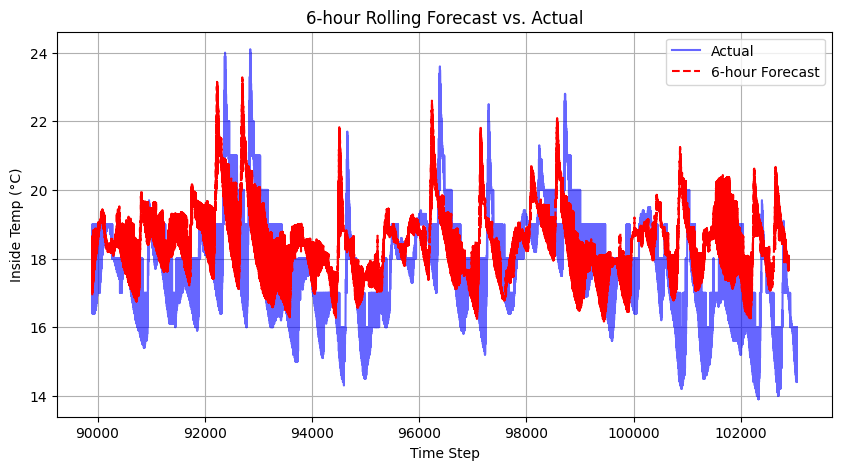

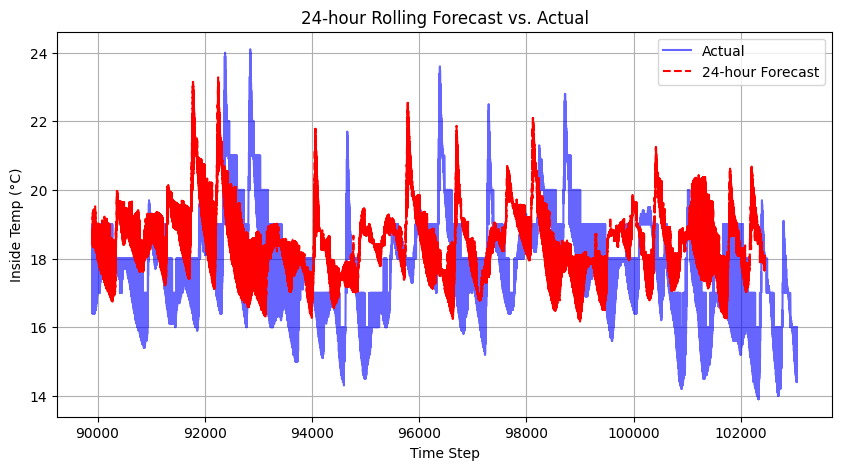

Rolling Forecasting Complete!


In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define exogenous variables (X)
exog_features = ["RH (%)", "Barometer - mb", "Inside Dew Point - °C", "Inside Heat Index - °C"]
train_X = train_df[exog_features].dropna()
test_X = test_df[exog_features].dropna()

# Align target variable with exogenous data
train_y = train_df.loc[train_X.index, "Inside Temp - °C"]
test_y = test_df.loc[test_X.index, "Inside Temp - °C"]

# Train SARIMAX model once
final_sarimax_model = SARIMAX(
    train_y,
    exog=train_X,
    order=(7, 1, 4),  # Best (p, d, q) from Grid Search
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

# Define forecast horizons
forecast_horizons = {
    "1-hour": 25,    # 25 steps (1-hour ahead forecast)
    "6-hour": 150,   # 150 steps (6-hour ahead forecast)
    "24-hour": 600   # 600 steps (24-hour ahead forecast)
}

# Dictionary to store rolling forecasts
rolling_forecasts = {key: [] for key in forecast_horizons}

# Start with known test data
rolling_history = list(train_y)

# Rolling Forecast Loop
for i in tqdm(range(len(test_y)), desc="Rolling Forecasting", unit="step"):
    # Get latest exogenous features
    current_exog = test_X.iloc[i].values.reshape(1, -1)

    # Generate predictions for each horizon
    for key, steps in forecast_horizons.items():
        if i + steps < len(test_y):
            forecast = final_sarimax_model.forecast(steps=steps, exog=test_X.iloc[i:i+steps])
            rolling_forecasts[key].append(forecast.iloc[-1])  # Store last forecasted value
        else:
            rolling_forecasts[key].append(np.nan)  # If not enough future data, store NaN

# Convert results to NumPy arrays for easier analysis
for key in rolling_forecasts:
    rolling_forecasts[key] = np.array(rolling_forecasts[key])

# Visualize Forecasts
for key in forecast_horizons:
    plt.figure(figsize=(10, 5))
    plt.plot(test_y, label="Actual", color="blue", alpha=0.6)
    plt.plot(test_y.index, rolling_forecasts[key], label=f"{key} Forecast", color="red", linestyle="dashed")
    plt.title(f"{key} Rolling Forecast vs. Actual")
    plt.xlabel("Time Step")
    plt.ylabel("Inside Temp (°C)")
    plt.legend()
    plt.grid(True)
    plt.show()

print("Rolling Forecasting Complete!")

# **SARIMAX Rolling Forecast Results Summary**

## **Overview**
The rolling forecast results for **1-hour, 6-hour, and 24-hour** predictions illustrate the model’s ability to capture short-term and long-term temperature trends. The model’s performance degrades as the prediction horizon increases.

## **Observations**
### **1-Hour Forecast**
- The **predicted** values closely follow actual temperatures.
- Captures short-term fluctuations effectively with minimal lag.
- The variance is well maintained, keeping the forecasted values within a reasonable range.

### **6-Hour Forecast**
- The model still follows the overall trend but starts **smoothing out variations**.
- Some local fluctuations are **not as well captured** as in the 1-hour forecast.
- Shows early signs of deviation from actual values.

### **24-Hour Forecast**
- The forecast still **captures general trends**, but accuracy declines significantly.
- The **long-term deviations** become more noticeable.
- Model loses fine-grained details, leading to a smoother forecast.

---

## **Discussion on Extreme Values**
1. **Sudden Spikes in Temperature:**
   - The model struggles with **extreme highs and lows**.
   - Some peaks are underpredicted, while others are **overestimated**.

2. **Deviation in Long-Term Predictions:**
   - The **24-hour forecast** smooths out fluctuations but **misses sharp temperature changes**.
   - This suggests the model might not fully capture **external influences or sudden environmental shifts**.

3. **Impact of Outliers:**
   - The **extreme dips and spikes** in the dataset could be affecting the forecast’s reliability.
   - Possible solutions: Incorporating **robust preprocessing techniques** to handle outliers.

---

## **Final Thoughts**
- The model performs well in short-term forecasting but **loses accuracy over longer periods**.
- Exogenous factors like **humidity, barometric pressure, and past extreme values** could be further optimized to improve forecasting accuracy.
- Future work could explore **hybrid models** that combine **SARIMAX with deep learning** to better capture sudden changes.